### CFM Challenge

Note : This model gives lower scores than the actual results on the challenge :

Indeed the notebook will give you around ~52.4 by averaging the LSTMs and the regression which will give around ~52.05 on the private leaderboard. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [2]:
x_train = pd.read_csv("x_train.csv", index_col=0)
y_train = pd.read_csv("y_train.csv", index_col=0)
x_test  = pd.read_csv("x_test.csv", index_col=0)

In [3]:
x_train.sort_values(by="date",inplace=True)
y_train = y_train.reindex(x_train.index,copy=True)
x_train.drop(['date'],axis=1,inplace=True)
x_test.drop(['date'],axis=1,inplace=True)

### Missing values

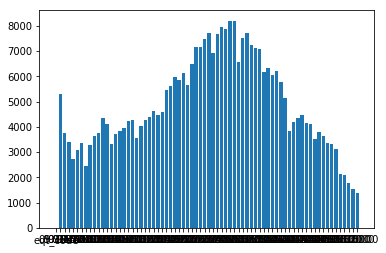

In [4]:
#Nan visualization

plt.bar(np.arange(x_train.shape[1]),pd.DataFrame(len(x_train.index)-x_train.count()).iloc[:,0].values)
plt.xticks(np.arange(x_train.shape[1]), tuple(x_train.columns))
# plt.savefig("nans.pdf")
plt.show()

In [5]:
# simple replacement by zero
x_train.fillna(0,inplace=True)
x_test.fillna(0,inplace=True)

### Feature engineering

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EB00FAA860>,
      dtype=object)

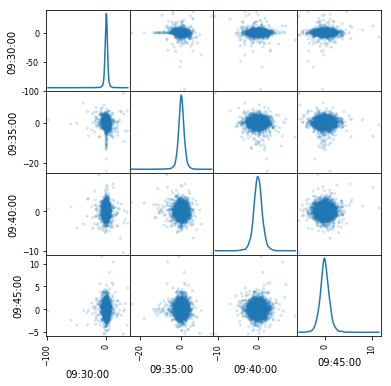

In [7]:
# Feature correlations
from pandas.plotting import scatter_matrix
scatter_matrix(x_train.iloc[:5000,1:5], alpha=0.2, figsize=(6, 6), diagonal='kde')
# plt.savefig("feature_feature.pdf")

In [8]:
# New features
mean = pd.DataFrame(x_train.groupby(['eqt_code']).mean().iloc[:,1:].sum(axis=1),columns=['mean'])
median = pd.DataFrame(x_train.groupby(['eqt_code']).median().iloc[:,1:].sum(axis=1),columns=['median'])
std = pd.DataFrame(x_train.groupby(['eqt_code']).std().iloc[:,1:].sum(axis=1),columns=['std'])

x_train = x_train.reset_index().merge(mean,on='eqt_code', how="left").set_index('ID')
x_train = x_train.reset_index().merge(median,on='eqt_code', how="left").set_index('ID')
x_train = x_train.reset_index().merge(std,on='eqt_code', how="left").set_index('ID')
x_train.drop('eqt_code',axis=1,inplace=True)
x_train['scaled'] = (x_train.iloc[:,:-3].sum(axis=1).sub(x_train['mean'])).divide(x_train['std'])
x_train['Minimum'] = x_train.iloc[:,:-4].min(axis=1)
x_train['Maximum'] = x_train.iloc[:,:-4].max(axis=1)

In [13]:
x_train.head()

,09:30:00,09:35:00,09:40:00,09:45:00,09:50:00,09:55:00,10:00:00,10:05:00,10:10:00,10:15:00,...,15:05:00,15:10:00,15:15:00,15:20:00,mean,median,std,scaled,Minimum,Maximum
ID,,,,,,,,,,,,,,,,,,,,,
670956,1.872936,-0.895033,0.731271,-0.572103,-0.505382,-0.393438,-0.511840,0.407902,0.757114,0.187825,...,-0.342364,-0.041825,0.560328,0.231219,0.126932,-0.091959,38.945352,0.072140,-1.033612,1.914107
504491,0.725170,0.541838,0.082966,-0.108649,0.669289,-0.609958,-0.061613,-0.022862,0.265052,0.203385,...,0.750487,-0.067995,0.243730,-0.188019,-0.251381,-0.436776,29.991448,0.048801,-0.864878,1.163951
439540,0.592828,-0.483862,-0.094134,0.000000,0.670562,-0.771782,-1.278793,0.971808,0.172689,-0.005296,...,0.222629,-0.100025,0.191086,0.144817,-0.013613,-0.013801,44.556605,0.065189,-1.278793,1.170502
154671,0.101024,0.692924,-1.595626,-0.001691,0.234374,0.632986,-0.862094,-0.109875,-0.365638,-0.195218,...,0.127854,-0.374174,0.246502,0.254038,0.183700,-0.127309,38.966204,-0.072333,-1.595626,0.692924
84183,0.177900,0.176035,0.286476,0.621928,0.321693,-1.033395,-0.193671,-0.538738,0.576359,-0.795727,...,-0.053302,-0.108594,-0.326036,0.263884,-0.201062,-0.489449,37.815976,0.077283,-1.033395,0.777480


In [14]:
x_test = x_test.reset_index().merge(mean,on='eqt_code', how="left").set_index('ID')
x_test = x_test.reset_index().merge(median,on='eqt_code', how="left").set_index('ID')
x_test = x_test.reset_index().merge(std,on='eqt_code', how="left").set_index('ID')
x_test.drop('eqt_code',axis=1,inplace=True)
x_test['scaled'] = (x_test.iloc[:,:-3].sum(axis=1).sub(x_test['mean'])).divide(x_test['std'])
x_test['Minimum'] = x_test.iloc[:,:-4].min(axis=1)
x_test['Maximum'] = x_test.iloc[:,:-4].max(axis=1)

In [22]:
n_samples = x_train.shape[0]
n = int(n_samples*.8)
X = x_train.copy().values[:n]
X_val = x_train.copy().values[n:]
y = y_train.copy().end_of_day_return.values[:n] #; y[y<0] = 0; y[y>0] = 1
y_val = y_train.copy().end_of_day_return.values[n:] #; y_val[y_val<0] = 0; y_val[y_val>0] = 1

In [16]:
def sign_acc(a,b):
    """
        returns the CFM_metric in case we chose the regression problem
    """
    _c = a*b
    _c[_c<0] = 0;_c[_c>0] = 1
    return np.mean(_c)

def CFM_metric(y_pred,y_true):
    """
        returns the CFM_metric in case we chose the classification problem
    """
    return np.mean(((y_true>0)==(y_pred>0.5)))

### Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()

In [24]:
lin_model.fit(X,y)
lin_preds = lin_model.predict(X_val)
print(sign_acc(lin_preds,y_val))

0.5192532166959601


### Lightgbm

In [19]:
import lightgbm as lgb

In [25]:
lgb_train = lgb.Dataset(X, y)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'l2', 'l1'},
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }
params = {
    'subsampleforbin': 200000,
    'boosting_type': 'gbdt',
    'silent': False,
    'minchildsamples': 20,
    'minchildweight': 0.001,
    'minsplitgain': 0.0,
    'random_state': None,
    'objective': None,
    'class_weight': None,
    'max_depth': -1,
    'num_leaves': 31,
    'reg_alpha': 0.0,
    'subsample_freq': 1,
    'learning_rate': 0.05,
    'n_estimators': 500,
    'colsample_bytree': 0.8,
    'subsample': 0.9,
    'reg_lambda': 0.0,
}

gbm = lgb.train(params, lgb_train)
# predict
# lgb_features = gbm.predict(x_train.copy().values, num_iteration=gbm.best_iteration)
lgb_preds = gbm.predict(X_val, num_iteration=gbm.best_iteration)

C:\Users\Reda\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Reda\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\basic.py:731: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


In [26]:
sign_acc(lgb_preds,y_val)

0.5204070680101431

### FFNNs

In [27]:
from keras.models import Sequential, model_from_json, Model
from keras.layers import Dense, Flatten, LSTM, Dropout, Input, concatenate, Conv1D
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.optimizers import adam
from sklearn.metrics import mean_squared_error
from keras import backend as K
import random
random.seed(777)     # fix seed for reproducibility

Using TensorFlow backend.


In [28]:
def cfm_metric(a,b):
    """
        returns the CFM_metric for tensorflow tensors
    """
    return K.mean(K.equal(K.greater(a,0),K.greater(b,0.5)),axis=-1)
def sign_metric(a,b):
    """
        returns the CFM_metric for tensorflow tensors in case of regression
    """
    return K.mean(K.greater(a*b,0.),axis=-1)

In [44]:
X_val.shape

(149066, 77)

In [45]:

def create_ff_model(X,n_outputs):
    """
        defines simple ffnn model
    """
    model = Sequential()
    model.add(Dense(25,input_shape=(X.shape[1],), activation='relu'))
    model.add(Dropout(rate=0.4))
    model.add(Dense(18, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam',metrics=[sign_metric])
    return model

def build_ff_model(X,X_val,y,y_val,n_outputs=1):
    """
        trains the model
    """
    model = create_ff_model(X,n_outputs)    
#     model.load_weights('weightsFFD034.h5')
    checkpointer = ModelCheckpoint('weightsFFD{epoch:03d}.h5', save_weights_only=True, period=2,verbose=0)
    verbose, epochs, batch_size = 0, 10, 1000
    # fit network
    hist = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[checkpointer])
    return model, hist

In [46]:
model, hist = build_ff_model(X,X_val,y,y_val,1)

Train on 596261 samples, validate on 149066 samples
Epoch 1/10
596261/596261 [==============================] - 20s 33us/step - loss: 1.0710 - sign_metric: 0.4993 - val_loss: 0.6888 - val_sign_metric: 0.4971
Epoch 2/10
596261/596261 [==============================] - 9s 16us/step - loss: 0.7121 - sign_metric: 0.4989 - val_loss: 0.6881 - val_sign_metric: 0.4973
Epoch 3/10
596261/596261 [==============================] - 10s 17us/step - loss: 0.7089 - sign_metric: 0.5013 - val_loss: 0.6881 - val_sign_metric: 0.5029
Epoch 4/10
596261/596261 [==============================] - 10s 16us/step - loss: 0.7079 - sign_metric: 0.5021 - val_loss: 0.6881 - val_sign_metric: 0.5029
Epoch 5/10
596261/596261 [==============================] - 11s 18us/step - loss: 0.7076 - sign_metric: 0.5021 - val_loss: 0.6881 - val_sign_metric: 0.5026
Epoch 6/10
596261/596261 [==============================] - 9s 15us/step - loss: 0.7074 - sign_metric: 0.5031 - val_loss: 0.6881 - val_sign_metric: 0.5029
Epoch 7/10
596

In [47]:
def plot_results(hist,save=False,name="results"):
     """
        plots the loss evolution for both the train and val sets
    """
    fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    ax[0].plot(hist.history['loss'])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].set_title('model train loss')
    ax[0].legend(['train'], loc='upper left')

    ax[1].plot(hist.history['val_loss'])
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('val_loss')
    ax[1].set_title('model dev loss')
    ax[1].legend(['dev'], loc='upper left')
    if save:
        fig.savefig(name+'.jpg')

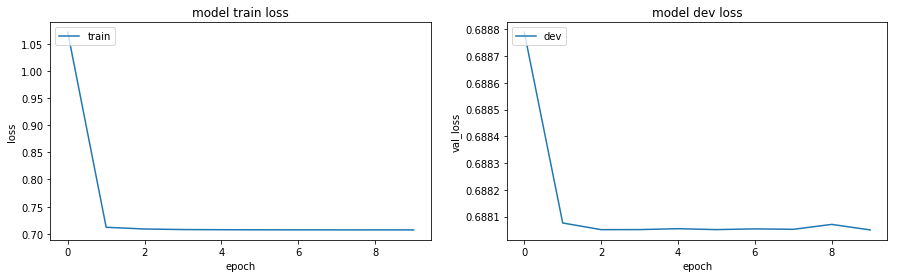

In [48]:
plot_results(hist)

### LSTMs

In [49]:
n_samples = x_train.shape[0]
n = int(n_samples*.8)
X = x_train.iloc[:,:-6].values[:n]; nX = x_train.iloc[:,:-6].values[:n]
X_val = x_train.iloc[:,:-6].values[n:]; nX_val = x_train.iloc[:,:-6].values[n:]
y = y_train.copy().end_of_day_return.values[:n] #; y[y<0] = 0; y[y>0] = 1
y_val = y_train.copy().end_of_day_return.values[n:] #; y_val[y_val<0] = 0; y_val[y_val>0] = 1

In [419]:
def create_lstm_model(X,nX,n_outputs=1):
     """
        creates lstm model with two inputs: time series and stock features
    """
    features = Input(shape=(X.shape[1], n_outputs), name='Features')
    new_features = Input(shape=(nX.shape[1],), name='new_Features')
    # define model
    lstm = Sequential()
    lstm.add(LSTM(144, input_shape=(X.shape[1], n_outputs)))
    lstm.add(Dropout(rate=0.2))
    lstm.add(Dense(24, activation='relu'))
    part1 = lstm(features)
    merged = concatenate([part1,new_features],axis=1)
    final = Dense(12, activation='relu')(merged)
    final = Dense(n_outputs)(final)
    model = Model(inputs=[features, new_features], outputs=[final])
    model.compile(loss='mae', optimizer='adam',metrics=[sign_metric])
    return model
# train the model
def build_model(X,nX,X_val,nX_val,y,y_val,n_outputs=1):
     """
        Builds the lstm model
    """
    X = X[...,None] 
    y = y[...,None]
    X_val = X_val[...,None]
    y_val = y_val[...,None]
    model = create_lstm_model(X,nX,n_outputs)    
    checkpointer = ModelCheckpoint('weights_lstm_{epoch:02d}.h5', save_weights_only=True, period=1)
    # define parameters
    verbose, epochs, batch_size = 0, 25, 2000
    # fit network
    hist = model.fit([X,nX], y, epochs=epochs, batch_size=batch_size, validation_data=([X_val,nX_val], y_val), callbacks=[checkpointer])
    return model, hist

In [420]:
model, hist = build_model(X,nX,X_val,nX_val,y,y_val,n_outputs=1)

Train on 596261 samples, validate on 149066 samples
Epoch 1/25
596261/596261 [==============================] - 148s 249us/step - loss: 0.7175 - sign_metric: 0.5041 - val_loss: 0.6881 - val_sign_metric: 0.5047
Epoch 2/25
596261/596261 [==============================] - 112s 188us/step - loss: 0.7074 - sign_metric: 0.5070 - val_loss: 0.6878 - val_sign_metric: 0.5106
Epoch 3/25
596261/596261 [==============================] - 112s 188us/step - loss: 0.7069 - sign_metric: 0.5131 - val_loss: 0.6877 - val_sign_metric: 0.5107
Epoch 4/25
596261/596261 [==============================] - 114s 191us/step - loss: 0.7064 - sign_metric: 0.5164 - val_loss: 0.6871 - val_sign_metric: 0.5199
Epoch 5/25
596261/596261 [==============================] - 114s 191us/step - loss: 0.7060 - sign_metric: 0.5199 - val_loss: 0.6870 - val_sign_metric: 0.5178
Epoch 6/25
596261/596261 [==============================] - 114s 192us/step - loss: 0.7058 - sign_metric: 0.5214 - val_loss: 0.6869 - val_sign_metric: 0.5215


KeyboardInterrupt: 

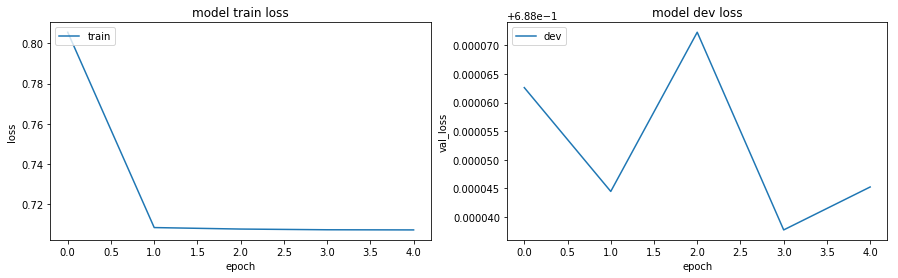

In [422]:
plot_results(hist,True,"lstm")

### Generate results

In [51]:
def create_model(X,which='lstm'):
    """
        creates the NNs model in order to load it with the best weights obtained during training
    """
    if which=='lstm':
        return create_lstm_model(X)
    else:
        return create_nn_model(X)
# model = create_model(X,'f')                    
# model.load_weights("weightsFFD034.h5")

In [ ]:
ffnn_preds = model.predict(X_test[...,None],batch_size=2000,verbose=1)[:,0]
# lstm_preds[lgb_preds<=0] = 0    # in Case of regression problem
# lgb_preds[lgb_preds>0] = 1
ffnn_results = pd.DataFrame({'end_of_day_return':ffnn_preds})
ffnn_results.index = index_test
ffnn_results.to_csv("ffnn_results.csv")
ffnn_results.head()